## Simulation codes for paper
### Code by: Jamie Kang (jamiekang@stanford.edu)

Last edit: March 26, 2021

There are three main simulations:

**Single Batch**

1. Simulating $\underline{\mu}(N;q)$ and $\overline{\mu}(N;q)$ for different ($N$, $q$) pairs

2. Simulating $N^*$ and $CRT^*$ for different ($\mu$, $q$) pairs


**Multiple Batches**

3. Simulating $N_i^*$ and $CRT_i^*$ with multiple batches for different ($\mu$, $q$) pairs

## 0. Setting up

### Import packages

In [2]:
#convenient math functions
from math import comb, ceil, log
from scipy.stats import binom

#other useful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import seaborn as sns
plt.rc('text', usetex=False)

### Functions to be used as building blocks

**Function Description**
* mid_tail(N,q): $Pr(X >= \frac{N+1}{2} | X \sim Binomial(N,q))$.
* lower_mu(N,q): $\underline{\mu}$ for given N and q.
* upper_mu(N,q): $\overline{\mu}$ for given N and q.
* correctness(N,q): $CRT_{Vote(N)}$ for given q. (For majority voting, this is equivalent to mid_tail(N,q))
* bg_ratio(N,q): $\frac{B(N)}{G(N)}$ for given q. (Not used often)

**Input parameters**
* $N$: Batch size
* $q$: Private signal quality

In [3]:
def mid_tail(N, q): #P(X >= (N+1)/2)
    min_y = ceil(N/2)
    return (1 - binom.cdf(min_y-1,N,q))

def lower_mu(N, q):
    return (1-mid_tail(N,q))

def upper_mu(N, q):
    return ((q**2 * lower_mu(N,q)) / (q**2 * lower_mu(N,q) + (1-q)**2 * (1-lower_mu(N,q))))

def correctness(N, q):
    return mid_tail(N,q)

def bg_ratio(N, q):
    return (q/(1-q) * (1/mid_tail(N,q) - 1))

## 1. Simulating $\underline{\mu}(N;q)$ and $\overline{\mu}(N;q)$ for different $N$ and $q$

**Input Paramters**:
* N_list: Values of $N$ to use -- *list, range or numpy array* 
* q_list: Values of $q$ to use -- *list, range or numpy array* 
* plot: Whether to plot the results -- *boolean*
* colors: Colors to use for plots. Not needed if *plot=False*. -- *list*

**Outputs**:
* lower_mu_list: $\underline{\mu}(N;q)$ for each $N$ (column) and $q$ (row) pair -- *pandas dataframe of dimension len(q_list) * len(N_list)*
* upper_mu_list:  $\overline{\mu}(N;q)$ for each $N$ (column) and $q$ (row) pair -- *pandas dataframe of dimension len(q_list) * len(N_list)*
* plot: feasible values of prior $\mu$ such that voting mechanism with the corresponding batch size $N$ (x-axis) is incentive compatible

In [4]:
def run_simulation(N_list=range(1,50,2), 
                   q_list = [0.55, 0.65, 0.75, 0.85, 0.95],
                   plot=True, colors = ['blue','green','gold','darkorange','red']): 
    
    lower_mu_list = pd.DataFrame(index=q_list, columns=N_list)
    upper_mu_list = pd.DataFrame(index=q_list, columns=N_list)
    
    for q in q_list:
        for N in N_list:
            lower_mu_list.loc[q,N] = lower_mu(N,q)
            upper_mu_list.loc[q,N] = upper_mu(N,q)
    
    if plot:
        for i in range(len(q_list)):
#             plt.plot(lower_mu_list.loc[q_list[i]], color=colors[i], linestyle='dashed', label='lower_mu')
#             plt.plot(upper_mu_list.loc[q_list[i]], color=colors[i], label='upper_mu')
            plt.vlines(N_list, lower_mu_list.loc[q_list[i]], upper_mu_list.loc[q_list[i]], linestyles='solid')
            plt.title('Feasible priors $\mu$ vs Batch size $N$ (for q=' +str(q_list[i])+')')
            plt.xlabel('Batch size (N)')
            plt.ylabel('Feasible priors $\mu$')
            plt.show()
            
    return lower_mu_list, upper_mu_list

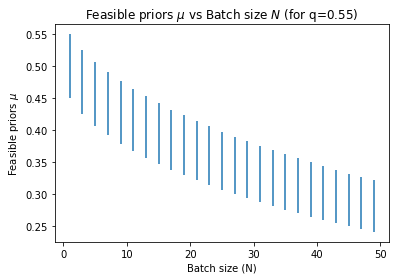

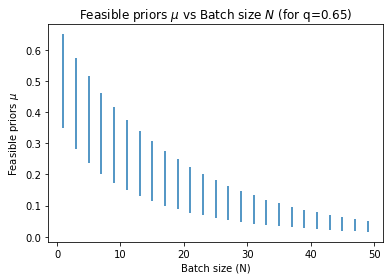

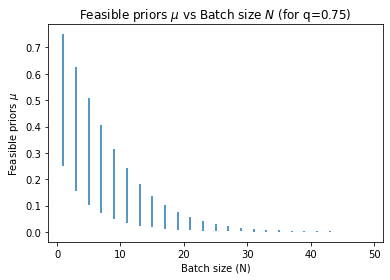

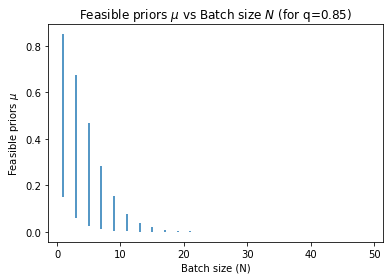

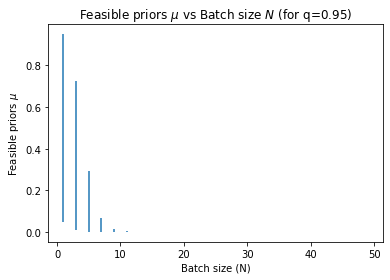

In [5]:
lower_mu_list, upper_mu_list = run_simulation()

---

## 2. Simulating $N^*$ for different $\mu$ and $q$

### 2.1 Compute N* for a given ($\mu$, q) pair
**Input Paramters**:
* mu: Object prior $\mu$ to optimize for
* q: Signal quality $q$ to optimize for

**Outputs**:
* N: Optimal IC batch size for specified $\mu$ and $q$

In [5]:
def optimal_N(mu, q):
    N = 0
    if mu <= q: #otherwise, return N=0
        N = 1
        
        while mu <= lower_mu(N,q):
            N = N+2
        
        while mu <= upper_mu(N+2, q):
            N = N+2
    return N

In [9]:
q = 0.70
mu = 0.53
N_opt = optimal_N(mu=mu, q=q)
print(N_opt)
print(upper_mu(N_opt,q), upper_mu(N_opt,q) >= mu) #sanity check that mu < upper_mu(N*)
print(lower_mu(N_opt,q), lower_mu(N_opt,q) <= mu) #sanity check that mu > lower_mu(N*)

3
0.6 True
0.21600000000000008 True


### 2.2 Simulate N* for various ($\mu$,q) pairs
**Input Paramters**:
* mu_list: Values of $\mu$ to use -- *list, range or numpy array* 
* q_list: Values of $q$ to use -- *list, range or numpy array* 
* plot: Whether to plot the results -- *boolean*
* colors: Colors to use for plots. Not needed if *plot=False*. -- *list*

**Outputs**:
* opt_N_list: List of optimal IC batch sizes, for each $\mu$ (column) and $q$ (row) -- *pandas dataframe of dimension len(q_list) * len(mu_list)*
* opt_crt_list: List of correctness under voting with the optimal IC batch sizes, for each $\mu$ (column) and $q$ (row) -- *pandas dataframe of dimension len(q_list) * len(mu_list)*

In [6]:
def opt_simulation(mu_list = np.linspace(0.0, 1.0, num=50, endpoint=False)[1:], 
                   q_list = [0.55, 0.65, 0.75, 0.85, 0.95],
                   plot=True, colors = ['blue','green','gold','darkorange','red']):    

    opt_N_list = pd.DataFrame(index=q_list, columns=mu_list)
    opt_crt_list = pd.DataFrame(index=q_list, columns=mu_list)
    for q in q_list:
        for mu in mu_list:
            if mu >= q: #Majority voting not IC. Do FCFS.
                opt_N_list.loc[q,mu] = None
                opt_crt_list.loc[q,mu] = None
            else:
                opt_N = optimal_N(mu,q)
                opt_N_list.loc[q,mu] = opt_N
                opt_crt_list.loc[q,mu] = correctness(opt_N,q)
            

    if plot:
        for i in range(len(q_list)):
            plt.scatter(mu_list, opt_N_list.loc[q_list[i]], color=colors[i], marker='.', s=15, label='q='+str(q_list[i]))
        plt.title('Optimal Batch size $N^*$ vs Object Prior $\mu$ for differnt $q$')
        plt.xlabel('Object Prior $\mu$')
        plt.ylabel('Optimal Batch Size $N^*$')
        plt.legend()
        plt.show()

        for i in range(len(q_list)):
            plt.plot(mu_list, opt_crt_list.loc[q_list[i]], color=colors[i], label='q='+str(q_list[i]))
        plt.title('Correctness under $Vote(N^*)$ vs Object Prior $\mu$ for different $q$')
        plt.xlabel('Object Prior $\mu$')
        plt.ylabel('CRT')
        plt.legend()
        plt.show()
        
    return opt_N_list, opt_crt_list

In [7]:
def seq_offer(mu, q):
    if mu > q:
        c = mu
    elif mu >= 0.5:
        c = 2*mu*q*(1-q) + q**2
    elif mu >= 1-q:
        c = q
    else:
        c = 1-mu
    return c

In [8]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

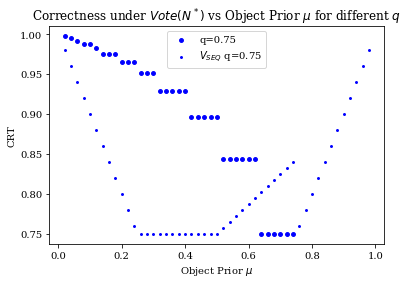

In [137]:
# q_list = [0.65, 0.75, 0.85]
q_list = [0.75]
mu_list = np.linspace(0.0, 1.0, num=50, endpoint=False)[1:]
colors = ['blue','green','gold','darkorange','red']

_, opt_crt_list = opt_simulation(q_list=q_list, mu_list=mu_list, plot=False)

seq_crt_list = pd.DataFrame(index=q_list, columns=mu_list)
for q in q_list:
    for mu in mu_list:
        seq_crt_list.loc[q,mu] = seq_offer(mu, q)

        
for i in range(len(q_list)):
#     plt.plot(mu_list, opt_crt_list.loc[q_list[i]], color=colors[i], label='q='+str(q_list[i]))
#     plt.plot(mu_list,seq_crt_list.loc[q_list[i]], '--', color=colors[i], label='$V_{SEQ}$ q='+str(q_list[i]))
    plt.scatter(mu_list, opt_crt_list.loc[q_list[i]], s=15,color=colors[i], label='q='+str(q_list[i]))
    plt.scatter(mu_list,seq_crt_list.loc[q_list[i]],  marker='.', s=15,color=colors[i], label='$V_{SEQ}$ q='+str(q_list[i]))

plt.title('Correctness under $Vote(N^*)$ vs Object Prior $\mu$ for different $q$')
plt.xlabel('Object Prior $\mu$')
plt.ylabel('CRT')
plt.legend()
plt.show()      


In [9]:
## Simulate $V_\text{ALL}$
def no_incentives(mu, q, I):
    min_y = 0.5* (np.log((1-mu)/mu)) / (np.log(q/(1-q))) + 0.5*I
    min_y = ceil(min_y)
    
    c = (1 - binom.cdf(min_y-1,I,q))
    return min_y, c

### Simulate $V_{GREEDY}^1, V_{SEQ}, V_{ALL}$

In [158]:
q_list = [0.60, 0.70, 0.80]
# q_list = [0.75]
mu_list = np.linspace(0.0, 1.0, num=1500, endpoint=False)[1:]
colors = ['blue','darkorange','gold','darkorange','red']


opt_min_y_list, opt_crt_list = opt_simulation(q_list=q_list, mu_list=mu_list, plot=False)
seq_crt_list = pd.DataFrame(index=q_list, columns=mu_list)

I = np.ceil(np.max(np.max(opt_min_y_list)) * 1.20)
# I = 80
no_inc_crt_list = pd.DataFrame(index=q_list, columns=mu_list)

for q in q_list:
    for mu in mu_list:
        seq_crt_list.loc[q,mu] = seq_offer(mu, q)
        no_inc_crt_list.loc[q,mu] = no_incentives(mu, q, I)[1]

opt_crt_list = opt_crt_list.fillna(value=np.nan)
seq_crt_list = seq_crt_list.fillna(value=np.nan)
no_inc_crt_list = no_inc_crt_list.fillna(value=np.nan)

In [159]:
opt_crt_list = pd.melt(opt_crt_list, 
        ignore_index=False).reset_index().rename(
        columns={'index': 'q', 'variable': 'mu', 'value': 'c'})
seq_crt_list = pd.melt(seq_crt_list, 
        ignore_index=False).reset_index().rename(
        columns={'index': 'q', 'variable': 'mu', 'value': 'c'})
no_inc_crt_list = pd.melt(no_inc_crt_list, 
        ignore_index=False).reset_index().rename(
        columns={'index': 'q', 'variable': 'mu', 'value': 'c'})
opt_crt_list.loc[:,'V'] = '$V_{OPT}^1$'
seq_crt_list.loc[:,'V'] = '$V_{SEQ}$'
no_inc_crt_list.loc[:,'V'] = '$V_{ALL}$'

df = pd.concat([opt_crt_list, seq_crt_list, no_inc_crt_list], axis=0).reset_index(drop=True)

([<matplotlib.axis.XTick at 0x7fd214aa7970>,
 [Text(-0.25, 0, '−0.25'),
  Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00')])

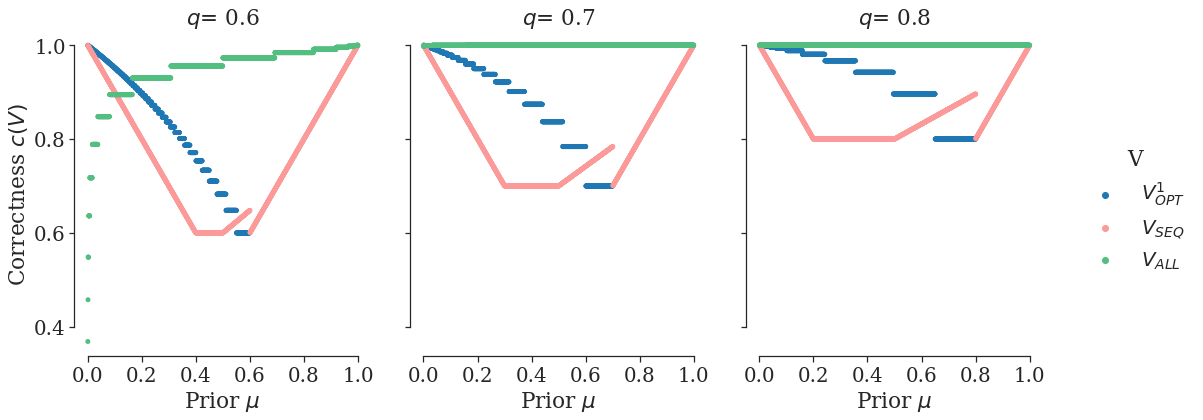

In [160]:
sns.set_theme(style="ticks", font_scale=1.8, font="serif", 
              rc={'figure.figsize':(30,15), "ytick.major.size": 5})
# sns.set_palette(["#1f78b4","#fb9a99","#bababa"])
sns.set_palette(["#1f78b4","#fb9a99","#52BE80"])

# g = plt.scatter(data=df, x="mu", y="c", hue="V", col="q", marker='.', edgecolor="none", s=12)

g = sns.relplot(data=df, x="mu", y="c", hue="V", col="q", marker='.', edgecolor="none", s=100)

(g.set_axis_labels("Prior $\mu$", "Correctness $c(V)$")
  .set_titles("$q$= {col_name}")
  .tight_layout(w_pad=1)
)
g.despine(trim=True)

fig = plt.gcf()
fig.set_size_inches( 17, 7)
plt.xticks(np.arange(0, 1.2, 0.2))

# plt.savefig('comparison.png')

# tikzplotlib.save("comparison.pgf")

# sns.despine(left=True)


### Simulate $V_{GREEDY}^1, V_{GREEDY}^2, V_{SEQ}, V_{ALL}$

In [29]:
### Simulate $V_\text{greedy}^2$

def greedy_2(mu,q):
    if mu >= q:
        return None
    else:
        return C(q=q,j=-1,mu=mu)
    
def C(q,j,mu):
    if j==0:
        K = optimal_N(mu, q)
        c = correctness(K,q)
    elif j<0:
        K = optimal_N(mu, q)
        c = mu * correctness(K,q) + future_value(q,j,mu,K)
    return c


def mu_update(q, mu, K, Y):
    mu = mu * (1-q)**(K-2*Y) / (mu * (1-q)**(K-2*Y) + (1-mu) * q**(K-2*Y))
    return mu

def prob_Y(q,mu,K,Y):
    pg = mu*binom.pmf(Y,K,q)
    pb = (1-mu)*binom.pmf(K-Y,K,q)
    return pg+pb

def future_value(q,j,mu,K):
    y_list = np.arange(0,ceil((K+1)/2),1)
    mu_next = mu_update(q,mu,K,y_list)
    pY = prob_Y(q,mu,K,y_list)
    C_map = lambda x: C(q,j+1,x)
    future_c_list = np.array(list(map(C_map, mu_next)))
    fv = np.dot(pY,future_c_list)
    return fv

# def future_value(q,j,mu,K):
#     fv = 0
#     for y in range(0,ceil((K+1)/2),1):
#         mu_next = mu_update(q,mu,K,y)
#         pY = prob_Y(q,mu,K,y)
#         fv = fv + pY*C(q,j+1,mu_next)
#     return fv


In [36]:
q_list = [0.60, 0.70, 0.80]
mu_list = np.linspace(0.0, 1.0, num=1500, endpoint=False)[1:]

greedy_2_crt_list = pd.DataFrame(index=q_list, columns=mu_list)


for q in q_list:
    print('q: ', q)
    for mu in mu_list:
        if mu >= q: #Majority voting not IC. Do FCFS.
            greedy_2_crt_list.loc[q,mu] = None
        else:
            print('mu: ', mu)
            greedy_2_crt_list.loc[q,mu] = greedy_2(mu, q)


greedy_2_crt_list = greedy_2_crt_list.fillna(value=np.nan)

greedy_2_crt_list = pd.melt(greedy_2_crt_list, 
        ignore_index=False).reset_index().rename(
        columns={'index': 'q', 'variable': 'mu', 'value': 'c'})
greedy_2_crt_list.loc[:,'V'] = '$V_{GREEDY}^2$'

# Take care of some underflow issues
greedy_2_crt_list.loc[:,'c'][[3590,3593,3596,3599]] = np.nan
greedy_2_crt_list.iloc[[3590,3593,3596,3599]] 

q:  0.6
mu:  0.0006666666666666666
mu:  0.0013333333333333333
mu:  0.002
mu:  0.0026666666666666666
mu:  0.003333333333333333
mu:  0.004
mu:  0.004666666666666666
mu:  0.005333333333333333
mu:  0.006
mu:  0.006666666666666666
mu:  0.007333333333333333
mu:  0.008
mu:  0.008666666666666666
mu:  0.009333333333333332
mu:  0.01
mu:  0.010666666666666666
mu:  0.011333333333333332
mu:  0.012
mu:  0.012666666666666666
mu:  0.013333333333333332
mu:  0.014
mu:  0.014666666666666666
mu:  0.015333333333333332
mu:  0.016
mu:  0.016666666666666666
mu:  0.017333333333333333
mu:  0.018
mu:  0.018666666666666665
mu:  0.019333333333333334
mu:  0.02
mu:  0.020666666666666667
mu:  0.021333333333333333
mu:  0.022
mu:  0.022666666666666665
mu:  0.02333333333333333
mu:  0.024
mu:  0.024666666666666667
mu:  0.025333333333333333
mu:  0.026
mu:  0.026666666666666665
mu:  0.02733333333333333
mu:  0.028
mu:  0.028666666666666667
mu:  0.029333333333333333
mu:  0.03
mu:  0.030666666666666665
mu:  0.0313333333333333

mu:  0.25666666666666665
mu:  0.2573333333333333
mu:  0.258
mu:  0.25866666666666666
mu:  0.2593333333333333
mu:  0.26
mu:  0.26066666666666666
mu:  0.2613333333333333
mu:  0.262
mu:  0.26266666666666666
mu:  0.2633333333333333
mu:  0.264
mu:  0.26466666666666666
mu:  0.2653333333333333
mu:  0.266
mu:  0.26666666666666666
mu:  0.2673333333333333
mu:  0.268
mu:  0.26866666666666666
mu:  0.2693333333333333
mu:  0.27
mu:  0.27066666666666667
mu:  0.2713333333333333
mu:  0.27199999999999996
mu:  0.27266666666666667
mu:  0.2733333333333333
mu:  0.27399999999999997
mu:  0.27466666666666667
mu:  0.2753333333333333
mu:  0.27599999999999997
mu:  0.27666666666666667
mu:  0.2773333333333333
mu:  0.27799999999999997
mu:  0.2786666666666667
mu:  0.2793333333333333
mu:  0.27999999999999997
mu:  0.2806666666666667
mu:  0.2813333333333333
mu:  0.282
mu:  0.2826666666666667
mu:  0.2833333333333333
mu:  0.284
mu:  0.2846666666666667
mu:  0.2853333333333333
mu:  0.286
mu:  0.2866666666666667
mu:  0.28733

mu:  0.53
mu:  0.5306666666666666
mu:  0.5313333333333333
mu:  0.532
mu:  0.5326666666666666
mu:  0.5333333333333333
mu:  0.534
mu:  0.5346666666666666
mu:  0.5353333333333333
mu:  0.536
mu:  0.5366666666666666
mu:  0.5373333333333333
mu:  0.538
mu:  0.5386666666666666
mu:  0.5393333333333333
mu:  0.54
mu:  0.5406666666666666
mu:  0.5413333333333333
mu:  0.542
mu:  0.5426666666666666
mu:  0.5433333333333333
mu:  0.5439999999999999
mu:  0.5446666666666666
mu:  0.5453333333333333
mu:  0.5459999999999999
mu:  0.5466666666666666
mu:  0.5473333333333333
mu:  0.5479999999999999
mu:  0.5486666666666666
mu:  0.5493333333333333
mu:  0.5499999999999999
mu:  0.5506666666666666
mu:  0.5513333333333333
mu:  0.5519999999999999
mu:  0.5526666666666666
mu:  0.5533333333333333
mu:  0.5539999999999999
mu:  0.5546666666666666
mu:  0.5553333333333333
mu:  0.5559999999999999
mu:  0.5566666666666666
mu:  0.5573333333333333
mu:  0.5579999999999999
mu:  0.5586666666666666
mu:  0.5593333333333333
mu:  0.559999

mu:  0.19066666666666665
mu:  0.19133333333333333
mu:  0.192
mu:  0.19266666666666665
mu:  0.19333333333333333
mu:  0.194
mu:  0.19466666666666665
mu:  0.19533333333333333
mu:  0.19599999999999998
mu:  0.19666666666666666
mu:  0.19733333333333333
mu:  0.19799999999999998
mu:  0.19866666666666666
mu:  0.19933333333333333
mu:  0.19999999999999998
mu:  0.20066666666666666
mu:  0.20133333333333334
mu:  0.20199999999999999
mu:  0.20266666666666666
mu:  0.20333333333333334
mu:  0.204
mu:  0.20466666666666666
mu:  0.20533333333333334
mu:  0.206
mu:  0.20666666666666667
mu:  0.20733333333333331
mu:  0.208
mu:  0.20866666666666667
mu:  0.20933333333333332
mu:  0.21
mu:  0.21066666666666667
mu:  0.21133333333333332
mu:  0.212
mu:  0.21266666666666667
mu:  0.21333333333333332
mu:  0.214
mu:  0.21466666666666667
mu:  0.21533333333333332
mu:  0.216
mu:  0.21666666666666665
mu:  0.21733333333333332
mu:  0.218
mu:  0.21866666666666665
mu:  0.21933333333333332
mu:  0.22
mu:  0.22066666666666665
mu:  0

mu:  0.4613333333333333
mu:  0.46199999999999997
mu:  0.46266666666666667
mu:  0.4633333333333333
mu:  0.46399999999999997
mu:  0.4646666666666667
mu:  0.4653333333333333
mu:  0.46599999999999997
mu:  0.4666666666666667
mu:  0.4673333333333333
mu:  0.46799999999999997
mu:  0.4686666666666667
mu:  0.4693333333333333
mu:  0.47
mu:  0.4706666666666667
mu:  0.4713333333333333
mu:  0.472
mu:  0.4726666666666666
mu:  0.47333333333333333
mu:  0.474
mu:  0.4746666666666666
mu:  0.47533333333333333
mu:  0.476
mu:  0.4766666666666666
mu:  0.47733333333333333
mu:  0.478
mu:  0.47866666666666663
mu:  0.47933333333333333
mu:  0.48
mu:  0.48066666666666663
mu:  0.48133333333333334
mu:  0.482
mu:  0.48266666666666663
mu:  0.48333333333333334
mu:  0.484
mu:  0.48466666666666663
mu:  0.48533333333333334
mu:  0.486
mu:  0.48666666666666664
mu:  0.48733333333333334
mu:  0.488
mu:  0.48866666666666664
mu:  0.48933333333333334
mu:  0.49
mu:  0.49066666666666664
mu:  0.49133333333333334
mu:  0.492
mu:  0.49

mu:  0.026
mu:  0.026666666666666665
mu:  0.02733333333333333
mu:  0.028
mu:  0.028666666666666667
mu:  0.029333333333333333
mu:  0.03
mu:  0.030666666666666665
mu:  0.03133333333333333
mu:  0.032
mu:  0.03266666666666666
mu:  0.03333333333333333
mu:  0.033999999999999996
mu:  0.034666666666666665
mu:  0.035333333333333335
mu:  0.036
mu:  0.03666666666666667
mu:  0.03733333333333333
mu:  0.038
mu:  0.03866666666666667
mu:  0.03933333333333333
mu:  0.04
mu:  0.04066666666666666
mu:  0.04133333333333333
mu:  0.041999999999999996
mu:  0.042666666666666665
mu:  0.043333333333333335
mu:  0.044
mu:  0.04466666666666667
mu:  0.04533333333333333
mu:  0.046
mu:  0.04666666666666666
mu:  0.04733333333333333
mu:  0.048
mu:  0.048666666666666664
mu:  0.04933333333333333
mu:  0.049999999999999996
mu:  0.050666666666666665
mu:  0.051333333333333335
mu:  0.052
mu:  0.05266666666666667
mu:  0.05333333333333333
mu:  0.054
mu:  0.05466666666666666
mu:  0.05533333333333333
mu:  0.056
mu:  0.0566666666666

mu:  0.2853333333333333
mu:  0.286
mu:  0.2866666666666667
mu:  0.28733333333333333
mu:  0.288
mu:  0.2886666666666667
mu:  0.28933333333333333
mu:  0.29
mu:  0.2906666666666667
mu:  0.29133333333333333
mu:  0.292
mu:  0.29266666666666663
mu:  0.29333333333333333
mu:  0.294
mu:  0.29466666666666663
mu:  0.29533333333333334
mu:  0.296
mu:  0.29666666666666663
mu:  0.29733333333333334
mu:  0.298
mu:  0.29866666666666664
mu:  0.29933333333333334
mu:  0.3
mu:  0.30066666666666664
mu:  0.30133333333333334
mu:  0.302
mu:  0.30266666666666664
mu:  0.30333333333333334
mu:  0.304
mu:  0.30466666666666664
mu:  0.30533333333333335
mu:  0.306
mu:  0.30666666666666664
mu:  0.30733333333333335
mu:  0.308
mu:  0.30866666666666664
mu:  0.30933333333333335
mu:  0.31
mu:  0.31066666666666665
mu:  0.3113333333333333
mu:  0.312
mu:  0.31266666666666665
mu:  0.3133333333333333
mu:  0.314
mu:  0.31466666666666665
mu:  0.3153333333333333
mu:  0.316
mu:  0.31666666666666665
mu:  0.3173333333333333
mu:  0.318


mu:  0.5506666666666666
mu:  0.5513333333333333
mu:  0.5519999999999999
mu:  0.5526666666666666
mu:  0.5533333333333333
mu:  0.5539999999999999
mu:  0.5546666666666666
mu:  0.5553333333333333
mu:  0.5559999999999999
mu:  0.5566666666666666
mu:  0.5573333333333333
mu:  0.5579999999999999
mu:  0.5586666666666666
mu:  0.5593333333333333
mu:  0.5599999999999999
mu:  0.5606666666666666
mu:  0.5613333333333334
mu:  0.5619999999999999
mu:  0.5626666666666666
mu:  0.5633333333333334
mu:  0.564
mu:  0.5646666666666667
mu:  0.5653333333333334
mu:  0.566
mu:  0.5666666666666667
mu:  0.5673333333333334
mu:  0.568
mu:  0.5686666666666667
mu:  0.5693333333333334
mu:  0.57
mu:  0.5706666666666667
mu:  0.5713333333333334
mu:  0.572
mu:  0.5726666666666667
mu:  0.5733333333333334
mu:  0.574
mu:  0.5746666666666667
mu:  0.5753333333333334
mu:  0.576
mu:  0.5766666666666667
mu:  0.5773333333333334
mu:  0.578
mu:  0.5786666666666667
mu:  0.5793333333333334
mu:  0.58
mu:  0.5806666666666667
mu:  0.58133333

In [ ]:
df = pd.concat([df, greedy_2_crt_list], axis=0).reset_index(drop=True)

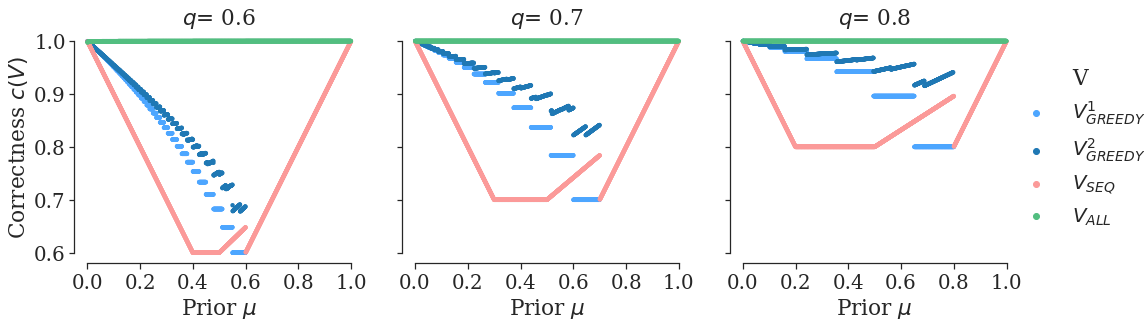

In [61]:
sns.set_theme(style="ticks", font_scale=1.8, font="serif", 
              rc={'figure.figsize':(35,12), "ytick.major.size": 5})
sns.set_palette(['#4da6ff','#1f78b4','#fb9a99','#52BE80'])

g = sns.relplot(data=df, x="mu", y="c", hue="V", col="q", marker='.', edgecolor="none", 
                s=80)

(g.set_axis_labels("Prior $\mu$", "Correctness $c(V)$")
  .set_titles("$q$= {col_name}")
  .tight_layout(w_pad=1)
)
g.despine(trim=True)

leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.5])

fig = plt.gcf()
fig.set_size_inches( 17, 5)
# fig.set_size_inches( 17, 7)
plt.xticks(np.arange(0, 1.2, 0.2))

plt.savefig('comparison.png')

# tikzplotlib.save("comparison.pgf")
# sns.despine(left=True)


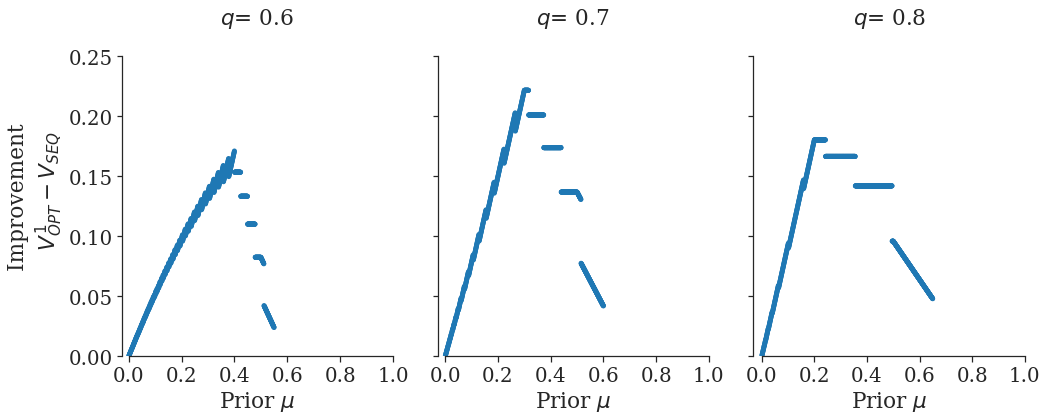

In [222]:
imp = df.loc[df.mu<= (df.q/2 + 1/4)]
imp = imp.loc[imp.V.isin(['$V_{OPT}^1$','$V_{SEQ}$'])]
imp = imp.loc[imp.V == '$V_{OPT}^1$'].merge(imp.loc[imp.V == '$V_{SEQ}$'], how='inner', on=['q','mu'])
imp.loc[:, '$V_{OPT}^1-V_{SEQ}$'] = imp.c_x-imp.c_y

sns.set_theme(style="ticks", font_scale=1.8, font="serif", 
              rc={"ytick.major.size": 5})
sns.set_palette(["#1f78b4","#fb9a99","#52BE80"])


g = sns.relplot(data=imp, x="mu", 
                y='$V_{OPT}^1-V_{SEQ}$', 
#                 hue="V", 
                col="q", marker='.', edgecolor="none", s=100,
               facet_kws={'sharey': True, 'sharex': False})
g.set(ylim=(0,max(imp.loc[:,'$V_{OPT}^1-V_{SEQ}$'])+0.05), 
      xticks=np.arange(0,1.2,0.2),
     yticks=np.arange(0,max(imp.loc[:,'$V_{OPT}^1-V_{SEQ}$'])+0.05,0.05))
(g.set_axis_labels("Prior $\mu$", "Improvement \n $V_{OPT}^1-V_{SEQ}$")
  .set_titles("$q$= {col_name}")
  .tight_layout(w_pad=1)
)
g.despine(trim=True)
# g.set(xticks=np.arange(0, 1.2, 0.2))

fig = plt.gcf()
fig.set_size_inches( 15, 7)
# plt.xticks(np.arange(0, 1.2, 0.2))


# plt.savefig('comparison.png')

# tikzplotlib.save("comparison.pgf")

# sns.despine(left=True)


In [183]:
imp

,q,mu,c_x,V_x,c_y,V_y,$V_{OPT}^1-V_{SEQ}$
0,0.6,0.000667,0.999694,$V_{OPT}^1$,0.999333,$V_{SEQ}$,0.000360
1,0.7,0.000667,0.999857,$V_{OPT}^1$,0.999333,$V_{SEQ}$,0.000524
2,0.8,0.000667,0.999945,$V_{OPT}^1$,0.999333,$V_{SEQ}$,0.000612
3,0.6,0.001333,0.999407,$V_{OPT}^1$,0.998667,$V_{SEQ}$,0.000740
4,0.7,0.001333,0.999750,$V_{OPT}^1$,0.998667,$V_{SEQ}$,0.001084
...,...,...,...,...,...,...,...
2695,0.8,0.647333,0.896000,$V_{OPT}^1$,0.847147,$V_{SEQ}$,0.048853
2696,0.8,0.648000,0.896000,$V_{OPT}^1$,0.847360,$V_{SEQ}$,0.048640
2697,0.8,0.648667,0.896000,$V_{OPT}^1$,0.847573,$V_{SEQ}$,0.048427
2698,0.8,0.649333,0.896000,$V_{OPT}^1$,0.847787,$V_{SEQ}$,0.048213


### Simulate K*

In [63]:
q_list = [0.60, 0.70, 0.80]
# q_list = [0.75]
mu_list = np.linspace(0.0, 1.0, num=100, endpoint=False)[1:]
opt_min_y_list, _ = opt_simulation(q_list=q_list, mu_list=mu_list, plot=False)
opt_min_y_list = opt_min_y_list.fillna(value=np.nan)
opt_min_y_list = pd.melt(opt_min_y_list, 
        ignore_index=False).reset_index().rename(
        columns={'index': 'q', 'variable': 'mu', 'value': 'K'})

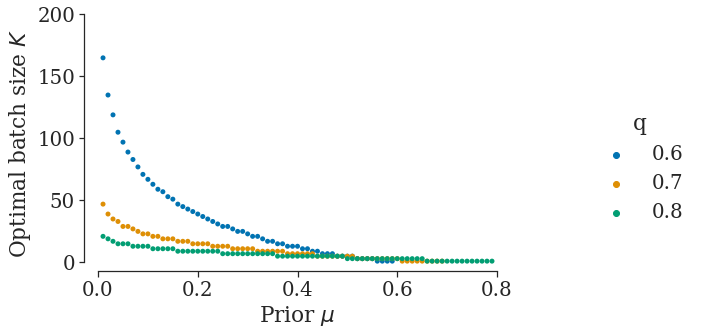

In [12]:
sns.set_theme(style="ticks", font_scale=1.8, font="serif", rc={"ytick.major.size": 5})
# sns.set_palette(["#1f78b4","#fb9a99","#bababa"])

g = sns.relplot(data=opt_min_y_list, x="mu", y="K", hue="q", marker='.', edgecolor="none", 
                s=100,palette="colorblind")
fig = plt.gcf()
fig.set_size_inches( 8, 4.5)
# fig.set_size_inches( 10, 5)

(g.set_axis_labels("Prior $\mu$", "Optimal batch size $K$")
#   .set_titles("$q$= {col_name}")
  .tight_layout(w_pad=1)
)
g.set(ylim=(None, 200))

leg = g._legend
leg.set_bbox_to_anchor([0.7, 0.55])

g.despine(trim=True)

# plt.xticks(np.arange(0, 1.2, 0.2))

# plt.savefig('optimal-K.png')

# tikzplotlib.save("comparison.pgf")

# sns.despine(left=True)
